In [1]:
from Favorfit_image_to_text import clip_image_to_text

clip_model = clip_image_to_text.load_interrogator("/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/image_to_text/clip", device="cuda")

/home/mlfavorfit/anaconda3/envs/diffusion_rnd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import random
import torch

from peft import LoraConfig
from transformers import CLIPVisionModelWithProjection
from diffusers import UNet2DConditionModel, VQModel, KandinskyV22PriorPipeline
from diffusers.pipelines.kandinsky2_2.pipline_kandinsky2_2_controlnet_split import KandinskyV22ControlnetPipeline
from diffusers.models.controlnet_kandinsky import ControlNetModel as ControlNetModelKandinsky
from diffusers import PriorTransformer
from diffusers.utils import make_image_grid

In [3]:
prior_model_path = "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/Kandinsky/kandinsky-prior"
decoder_model_path = "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/Kandinsky/kandinsky-decoder"

In [4]:
movq = VQModel.from_pretrained(
            decoder_model_path, subfolder="movq", torch_dtype=torch.float16
        ).eval()
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    prior_model_path, subfolder="image_encoder", torch_dtype=torch.float16
).eval()

prior = PriorTransformer.from_pretrained(
    prior_model_path, subfolder="prior", torch_dtype=torch.float16
).eval()
unet = UNet2DConditionModel.from_pretrained(
    decoder_model_path, subfolder="unet", torch_dtype=torch.float16
).eval()

controlnet_kandinsky = ControlNetModelKandinsky.from_pretrained(
    decoder_model_path, subfolder="controlnet/canny", torch_dtype=torch.float16
).eval()

The config attributes {'center_input_sample': False} were passed to ControlNetModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [5]:
prior_pipeline = KandinskyV22PriorPipeline.from_pretrained(
        prior_model_path,
        image_encoder=image_encoder,
        prior=prior,
        torch_dtype=torch.float16,
    )
pipeline = KandinskyV22ControlnetPipeline.from_pretrained(
    decoder_model_path,
    movq=movq,
    controlnet=controlnet_kandinsky,
    # unet=unet,
    torch_dtype=torch.float16,
)

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 10.38it/s]
The config attributes {'text_encoder': ['transformers', 'CLIPTextModel'], 'tokenizer': ['transformers', 'CLIPTokenizer']} were passed to KandinskyV22ControlnetPipeline, but are not expected and will be ignored. Please verify your model_index.json configuration file.
Keyword arguments {'text_encoder': ['transformers', 'CLIPTextModel'], 'tokenizer': ['transformers', 'CLIPTokenizer']} are not expected by KandinskyV22ControlnetPipeline and will be ignored.
Loading pipeline components...: 100%|██████████| 3/3 [00:00<00:00,  8.54it/s]


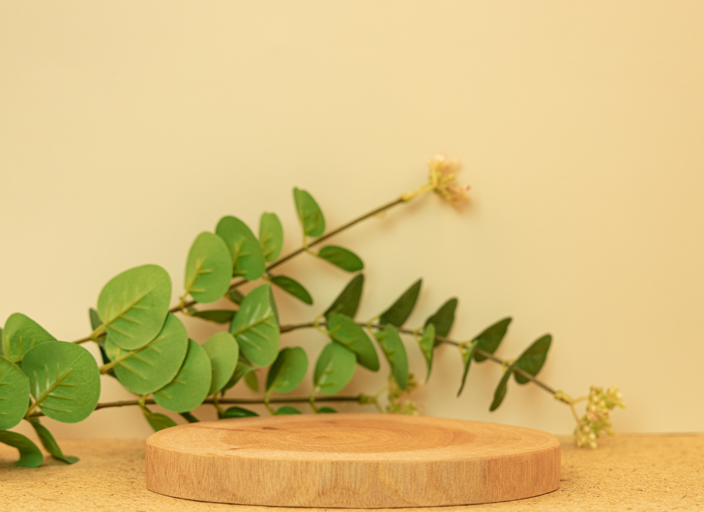

In [6]:
from utils import *
from PIL import Image

init_image = Image.open("/media/mlfavorfit/sdb/favorfit_templates/templates/180/1000.jpg").convert("RGB")
init_image = resize_store_ratio(init_image, 512)
init_image = init_image.resize((round(cur/64) * 64 for cur in init_image.size))
canny_image = make_canny_condition(init_image)
width, height = init_image.size
init_image

In [7]:
prompt = "vivid, clean, masterpiece, bestquality, photographed in a realistic style, high-resolution realistic image, pastel color"
negative_prompt = "human, including any identifying information such as logos, brand names, or product numbers. referencing copyrighted images or other product templates. generating low-resolution, blurry, or unclear images. having the product be disproportionate or distorted. Avoid generating images with the product damaged or altered."

In [14]:
prior_pipeline = prior_pipeline.to("cuda")
pipeline = pipeline.to("cuda")

num_images_per_prompt = 4
generator = [torch.Generator(device="cuda").manual_seed(random.randint(0,100000)) for _ in range(num_images_per_prompt)]

with torch.autocast("cuda", torch.float16):
    prior_output = prior_pipeline(
        prompt="product photo background",
        negative_prompt=negative_prompt, 
        generator=generator
    )

    generated_image = pipeline(
        image=init_image,
        control_image=canny_image,
        **prior_output,
        height=height,
        width=width,
        num_inference_steps=50,
        strength=1.0,
        guidance_scale=4.0,
        controlnet_scale=0.0,
        generator=generator,
        num_images_per_prompt=num_images_per_prompt
    ).images

100%|██████████| 50/50 [00:18<00:00,  2.77it/s]


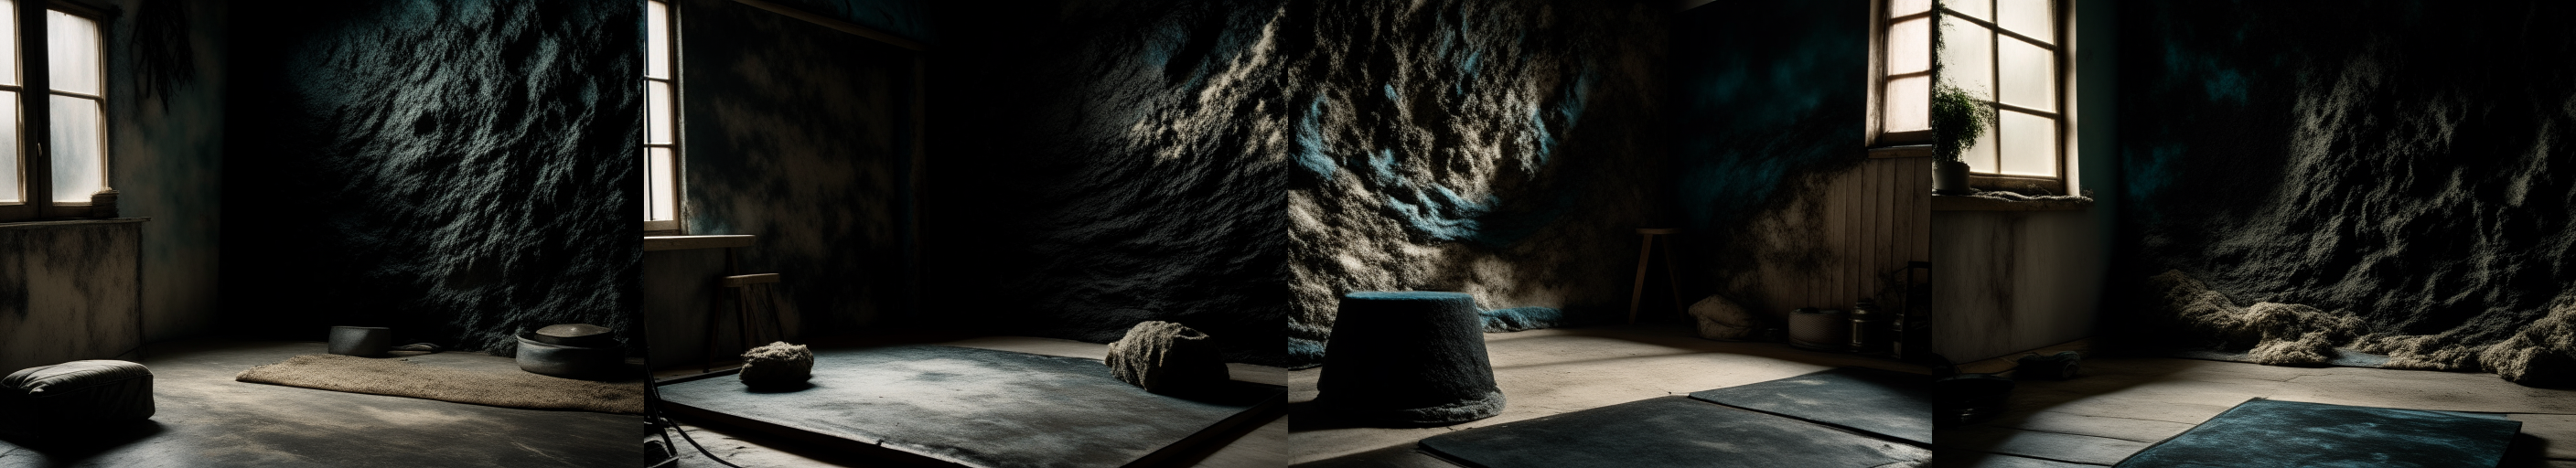

In [15]:
make_image_grid(generated_image,1,4)

In [4]:
from transformers import DPTFeatureExtractor, DPTForDepthEstimation
depth_estimator = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas").to("cuda")
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-hybrid-midas")

def get_depth_map(image):
    image = feature_extractor(images=image, return_tensors="pt").pixel_values.to("cuda")
    with torch.no_grad(), torch.autocast("cuda"):
        depth_map = depth_estimator(image).predicted_depth

    depth_map = torch.nn.functional.interpolate(
        depth_map.unsqueeze(1),
        size=init_image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )
    depth_min = torch.amin(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_max = torch.amax(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_map = (depth_map - depth_min) / (depth_max - depth_min)
    image = torch.cat([depth_map] * 3, dim=1)

    image = image.permute(0, 2, 3, 1).cpu().numpy()[0]
    image = Image.fromarray((image * 255.0).clip(0, 255).astype(np.uint8))
    return image

depth_image = get_depth_map(init_image)

/home/mlfavorfit/anaconda3/envs/diffusion_rnd/lib/python3.10/site-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(


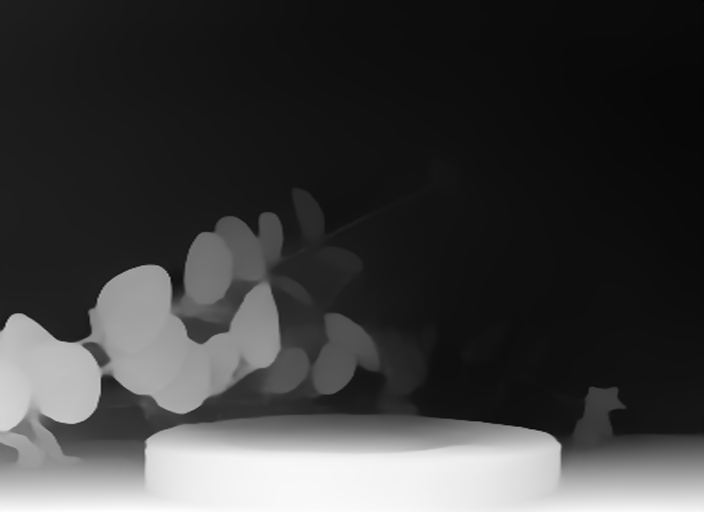

In [5]:
depth_image

In [6]:
positice_prompt2 = "natural materials, clean 3 d render, raytraced 3d set design, raytracing shadows, image on the store website, natural materials :: high detail, behance. polished, trending on textures. com, clean 3 d render, raytraced 3d set design, raytracing shadows, image on the store website"
positice_prompt3 = ", " + clip_image_to_text.inference(init_image, clip_model, mode="simple" ,remove_color=True)

prompt = positice_prompt2
negative_prompt = "blurry, low quality, worst quality, wrinkled, deformed, distorted, jpeg artifacts, nsfw, paintings, sketches, text, watermark, username, spikey"

In [10]:
positice_prompt2 = "natural materials, clean 3 d render, raytraced 3d set design, raytracing shadows, image on the store website, natural materials :: high detail, behance. polished, trending on textures. com, clean 3 d render, raytraced 3d set design, raytracing shadows, image on the store website"
positice_prompt3 = ", " + clip_image_to_text.inference(init_image, clip_model, mode="simple" ,remove_color=True)
test_prompt = "vivid, clean, masterpiece, bestquality, ultra-detailed, studio photography, realistic, Photography, RAW photo, volumetric lighting"
test_negative_prompt = "watermark, text, (depth of field:1.4),(bokeh:1.31),(blurry:1.4),(worst quality:1.4),(low quality:1.4),(monochrome:1.1),Sketch,ng_deepnegative_v1_75t,(nsfw:1.21),tattoo,(beard:1.3),(EasyNegative:1.3),badhandv4,(Teeth:1.3),(worst quality:2),(low quality:2),(normal quality:2),lowers,normal quality,facing away,looking away,text,error,extra digit,fewer digits,cropped,jpeg artifacts,signature,watermark,username,blurry,skin spots,acnes,skin blemishes,bad anatomy,fat,bad feet,cropped,poorly drawn hands,poorly drawn face,mutation,deformed,tilted head.bad anatomy.bad hands,extra fingers,fewer digits.,extra limbs.extra arms,extra legs,malformed limbs.fused fingers.,too many fingers,long neck,cross-eyed,mutated hands,bad body,bad proportions,gross proportions,text,error,missing fingers,missing arms,missing legs,extra digit,extra arms,extra leg,extra foot,missing fingers"

# test_negative_prompt = ", (deformed, distorted, disfigured:1.3), poorly drawn, bad anatomy, wrong anatomy, extra limb, missing limb, floating limbs, (mutated hands and fingers:1.4), disconnected limbs, mutation, mutated, ugly, disgusting, blurry, amputation, visible skin, (((necklace))) exposed chest, large breasts, big breasts,hair, fur, split in the middle, (worst quality, low quality:2), NSFW, monochrome, zombie, overexposure, watermark, text, bad anatomy, bad hand, extra hands, extra fingers, too many fingers, fused fingers, bad arm, distorted arm, extra arms, fused arms, extra legs, missing leg, disembodied leg, extra nipples, detached arm, liquid hand, inverted hand, disembodied limb, oversized head, extra body, extra navel, (hair between eyes),sketch, duplicate, ugly, huge eyes, text, logo, worst face, (bad and mutated hands:1.3), (blurry:2.0), horror, geometry, bad_prompt, (bad hands), (missing fingers), multiple limbs, bad anatomy, (interlocked fingers:1.2), Ugly Fingers, (extra digit and hands and fingers and legs and arms: 1.4), (deformed fingers: 1.2), (long fingers:1.2),(bad-artist-anime), bad-artist, bad hand, extra legs, close up, cropped, blurry, unbalanced"

prompt = "red" + positice_prompt2
negative_prompt = "blurry, low quality, worst quality, wrinkled, deformed, distorted, jpeg artifacts, nsfw, paintings, sketches, text, watermark, username, spikey"
concept = ["minimalism", "3d render", "modernism"]


# test_prompt = "45 megapixel, ethereal beauty of a mystical landscape under the green moonlight, The scene should be illuminated by a large, radiant moon, casting its glow upon a twisted, yet majestic tree with blossoms that seem to sparkle in the night, The treeâs roots should be deeply embedded into rocky terrain, symbolizing its ancient existence. In the background, towering mountains loom, their peaks veiled in mist, A serene lake at the foot of the mountains reflects the moonâs luminescence, Incorporate elements that evoke a sense of magic and mystery, limitless lights in the air"
# test_negative_prompt = "bad quality, bad anatomy, worst quality, low quality, low resolution, extra fingers, blur, blurry, ugly, wrong proportions, watermark, image artifacts, lowres, ugly,  jpeg artifacts, deformed, noisy image, deformation, skin moles"

prompt = test_prompt
negative_prompt = test_negative_prompt

In [11]:
seed = 42

In [62]:
import random

pipeline.to("cuda")
generator = torch.Generator(device="cuda").manual_seed(random.randint(0,10000))

output = pipeline(
    image=init_image,
    control_image=depth_image,
    prompt=prompt,
    negative_prompt=negative_prompt,
    strength=1.0,
    num_inference_steps=20,
    guidance_scale=5.0,
    generator=generator,
    controlnet_conditioning_scale = 0.8,
    clip_skip=2,
).images[0]

100%|██████████| 20/20 [00:04<00:00,  4.90it/s]


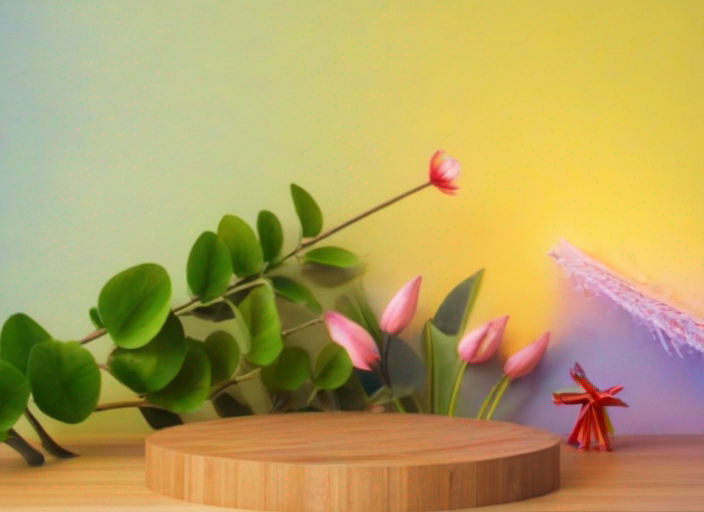

In [63]:
output

In [637]:
import torch
import numpy as np

from transformers import pipeline
from diffusers.utils import load_image

from diffusers import KandinskyV22PriorPipeline
from diffusers.pipelines.kandinsky2_2.pipeline_kandinsky2_2_controlnet_img2img import KandinskyV22ControlnetImg2ImgPipeline

# let's take an image and extract its depth map.
def make_hint(image, depth_estimator):
    image = depth_estimator(image)["depth"]
    image = np.array(image)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    detected_map = torch.from_numpy(image).float() / 255.0
    hint = detected_map.permute(2, 0, 1)
    return hint

# We can use the `depth-estimation` pipeline from transformers to process the image and retrieve its depth map.
depth_estimator = pipeline("depth-estimation")
hint = make_hint(init_image, depth_estimator).unsqueeze(0).half().to("cuda")

# Now, we load the prior pipeline and the text-to-image controlnet pipeline
pipe_prior = KandinskyV22PriorPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-2-prior", torch_dtype=torch.float16
)
pipe_prior = pipe_prior.to("cuda")

pipe = KandinskyV22ControlnetImg2ImgPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-2-controlnet-depth", torch_dtype=torch.float16
)
pipe = pipe.to("cuda")

No model was supplied, defaulted to Intel/dpt-large and revision e93beec (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extr

In [811]:
positice_prompt2 = "natural materials, clean 3 d render, raytraced 3d set design, raytracing shadows, image on the store website, natural materials :: high detail, behance. polished, trending on textures. com, clean 3 d render, raytraced 3d set design, raytracing shadows, image on the store website"
positice_prompt3 = ", " + clip_image_to_text.inference(init_image, clip_model, mode="simple" ,remove_color=True)
# test_prompt = "vivid, clean, masterpiece, bestquality, ultra-detailed, studio photography, realistic, Photography, RAW photo, volumetric lighting"
test_negative_prompt = "watermark, text, (depth of field:1.4),(bokeh:1.31),(blurry:1.4),(worst quality:1.4),(low quality:1.4),(monochrome:1.1),Sketch,ng_deepnegative_v1_75t,(nsfw:1.21),tattoo,(beard:1.3),(EasyNegative:1.3),badhandv4,(Teeth:1.3),(worst quality:2),(low quality:2),(normal quality:2),lowers,normal quality,facing away,looking away,text,error,extra digit,fewer digits,cropped,jpeg artifacts,signature,watermark,username,blurry,skin spots,acnes,skin blemishes,bad anatomy,fat,bad feet,cropped,poorly drawn hands,poorly drawn face,mutation,deformed,tilted head.bad anatomy.bad hands,extra fingers,fewer digits.,extra limbs.extra arms,extra legs,malformed limbs.fused fingers.,too many fingers,long neck,cross-eyed,mutated hands,bad body,bad proportions,gross proportions,text,error,missing fingers,missing arms,missing legs,extra digit,extra arms,extra leg,extra foot,missing fingers"

test_prompt = "extremely detailed, ultra-realistic"
# test_negative_prompt = ", (deformed, distorted, disfigured:1.3), poorly drawn, bad anatomy, wrong anatomy, extra limb, missing limb, floating limbs, (mutated hands and fingers:1.4), disconnected limbs, mutation, mutated, ugly, disgusting, blurry, amputation, visible skin, (((necklace))) exposed chest, large breasts, big breasts,hair, fur, split in the middle, (worst quality, low quality:2), NSFW, monochrome, zombie, overexposure, watermark, text, bad anatomy, bad hand, extra hands, extra fingers, too many fingers, fused fingers, bad arm, distorted arm, extra arms, fused arms, extra legs, missing leg, disembodied leg, extra nipples, detached arm, liquid hand, inverted hand, disembodied limb, oversized head, extra body, extra navel, (hair between eyes),sketch, duplicate, ugly, huge eyes, text, logo, worst face, (bad and mutated hands:1.3), (blurry:2.0), horror, geometry, bad_prompt, (bad hands), (missing fingers), multiple limbs, bad anatomy, (interlocked fingers:1.2), Ugly Fingers, (extra digit and hands and fingers and legs and arms: 1.4), (deformed fingers: 1.2), (long fingers:1.2),(bad-artist-anime), bad-artist, bad hand, extra legs, close up, cropped, blurry, unbalanced"

prompt = "red" + positice_prompt2
negative_prompt = "blurry, low quality, worst quality, wrinkled, deformed, distorted, jpeg artifacts, nsfw, paintings, sketches, text, watermark, username, spikey"
concept = ["minimalism", "3d render", "modernism"]


# test_prompt = "45 megapixel, ethereal beauty of a mystical landscape under the green moonlight, The scene should be illuminated by a large, radiant moon, casting its glow upon a twisted, yet majestic tree with blossoms that seem to sparkle in the night, The treeâs roots should be deeply embedded into rocky terrain, symbolizing its ancient existence. In the background, towering mountains loom, their peaks veiled in mist, A serene lake at the foot of the mountains reflects the moonâs luminescence, Incorporate elements that evoke a sense of magic and mystery, limitless lights in the air"
# test_negative_prompt = "bad quality, bad anatomy, worst quality, low quality, low resolution, extra fingers, blur, blurry, ugly, wrong proportions, watermark, image artifacts, lowres, ugly,  jpeg artifacts, deformed, noisy image, deformation, skin moles"

prompt = test_prompt
negative_prompt = test_negative_prompt

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext

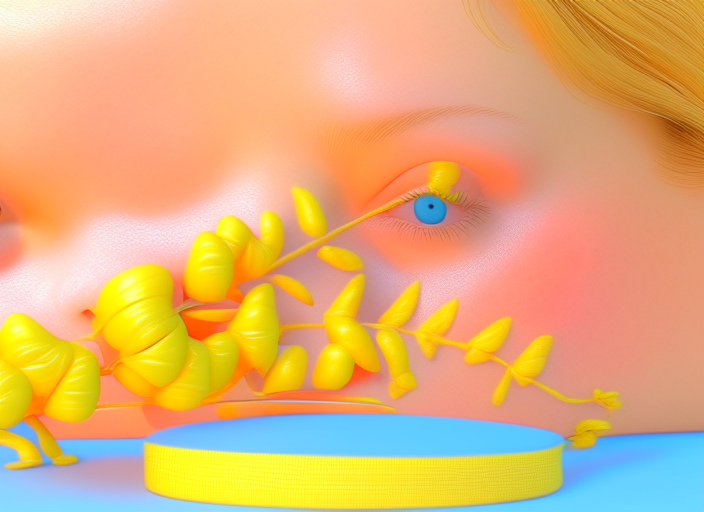

In [818]:
import random

# We pass the prompt and negative prompt through the prior to generate image embeddings
generator = torch.Generator(device="cuda").manual_seed(random.randint(0,10000))
image_emb, zero_image_emb = pipe_prior(
    prompt=prompt, negative_prompt=negative_prompt, generator=generator
).to_tuple()

# Now we can pass the image embeddings and the depth image we extracted to the controlnet pipeline. With Kandinsky 2.2, only prior pipelines accept `prompt` input. You do not need to pass the prompt to the controlnet pipeline.
images = pipe(
    image=init_image,
    image_embeds=image_emb,
    negative_image_embeds=zero_image_emb,
    hint=hint,
    num_inference_steps=20,
    generator=generator,
    guidance_scale=4.0,
    height=height,
    width=width,
    strength=1.0,
).images
images[0]
